In [12]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
def parse_collision_boxes(urdf_file):
    # Parse the URDF file
    tree = ET.parse(urdf_file)
    root = tree.getroot()

    boxes = []
    
    for link in root.findall("link"):
        for collision in link.findall("collision"):
            geometry = collision.find("geometry")
            box = geometry.find("box")
            if box is not None:
                size = list(map(float, box.attrib["size"].split()))
                origin_elem = collision.find("origin")
                if origin_elem is not None:
                    origin = list(map(float, origin_elem.attrib["xyz"].split()))
                    rpy = list(map(float, origin_elem.attrib["rpy"].split()))
                else:
                    origin = [0.0, 0.0, 0.0]
                    rpy = [0.0, 0.0, 0.0]
                boxes.append((size, origin, rpy))
    return boxes

def compute_min_max(size, origin, rpy):
    # Unpack size and origin
    sx, sy, sz = size
    ox, oy, oz = origin
    
    # Half extents
    hx, hy, hz = sx / 2, sy / 2, sz / 2
    
    # Define corners of the box relative to origin
    corners = np.array([
        [-hx, -hy, -hz],
        [-hx, -hy, hz],
        [-hx, hy, -hz],
        [-hx, hy, hz],
        [hx, -hy, -hz],
        [hx, -hy, hz],
        [hx, hy, -hz],
        [hx, hy, hz],
    ])
    
    # Rotation matrix for z-axis only (rpy[2])
    theta = rpy[2]
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])
    
    # Rotate and translate corners
    transformed_corners = np.dot(corners, rotation_matrix.T) + np.array([ox, oy, oz])
    
    # Get min and max
    min_coords = transformed_corners.min(axis=0)
    max_coords = transformed_corners.max(axis=0)
    
    return min_coords, max_coords

In [13]:
urdf_file = "model.urdf"
boxes = parse_collision_boxes(urdf_file)

global_min = np.array([float('inf'), float('inf'), float('inf')])
global_max = np.array([-float('inf'), -float('inf'), -float('inf')])

mins = []
maxs = []
for size, origin, rpy in boxes:
    min_coords, max_coords = compute_min_max(size, origin, rpy)
    mins.append(min_coords)
    maxs.append(max_coords)
    #print(f"Box: Size={size}, Origin={origin}, RPY={rpy}")
    #print(f"  Min: {min_coords}")
    #print(f"  Max: {max_coords}")
    
    # Update global bounds
    global_min = np.minimum(global_min, min_coords)
    global_max = np.maximum(global_max, max_coords)

print("\nGlobal Bounds:")
print(f"  Global Min: {global_min.round(3)}")
print(f"  Global Max: {global_max.round(3)}")


Global Bounds:
  Global Min: [-2.275 -2.525  0.   ]
  Global Max: [2.275 2.025 0.3  ]


In [14]:
buffer=0.1
adjusted_min = np.array(mins) - buffer
adjusted_max = np.array(maxs) + buffer

In [15]:
# Function to create a 2D grid with coordinates
cell_size = 0.1  # Adjust for finer or coarser grids

# Calculate number of rows and columns
rows = int(np.ceil((global_max[1] - global_min[1]) / cell_size))
cols = int(np.ceil((global_max[0]- global_min[0]) / cell_size))


# Create a 2D grid of coordinates
node_grid = np.zeros((rows, cols, 2))  # 2 for x and y coordinates

# Fill the grid with node coordinates
for i in range(rows):
    for j in range(cols):
        x = global_min[0] + j * cell_size
        y = global_min[1] + i * cell_size
        node_grid[i, j] = [x, y]

print("Node Grid Dimensions:", node_grid.shape)  # Should be (rows, cols, 2)
print("Example Node at (0,0):", node_grid[0, 0])



Node Grid Dimensions: (46, 46, 2)
Example Node at (0,0): [-2.27501982 -2.52521898]


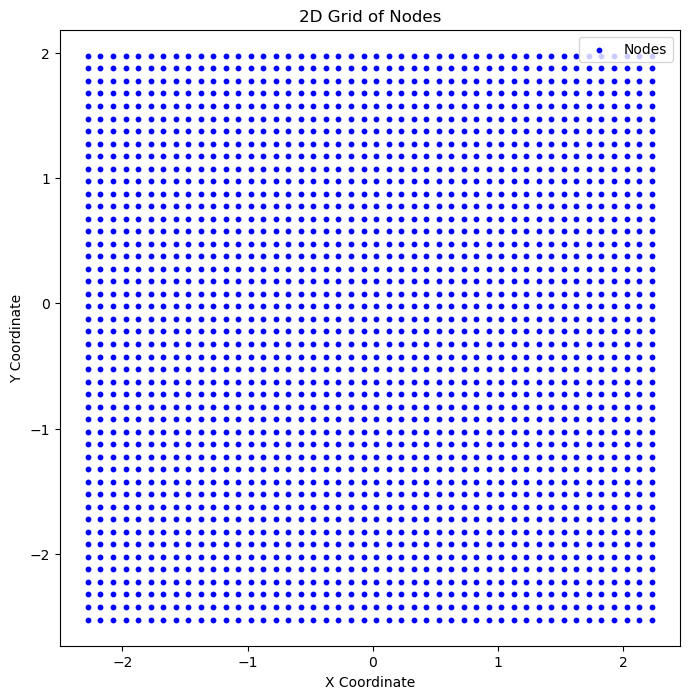

In [16]:
x_coords = node_grid[:, :, 0].flatten()
y_coords = node_grid[:, :, 1].flatten()

# Plot the grid of nodes
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, s=10, c='blue', label="Nodes")
plt.title("2D Grid of Nodes")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.axis("equal")
plt.legend()
plt.show()

In [17]:
def check_collision(coords):
    coords = np.array(coords)
    if coords.shape[0] == 2:
        coords = np.array(list(coords) + [0.1])
    for i in range(len(boxes)):
        if np.all((coords >= adjusted_min[i]) & (coords <= adjusted_max[i])):
            return True

    return False

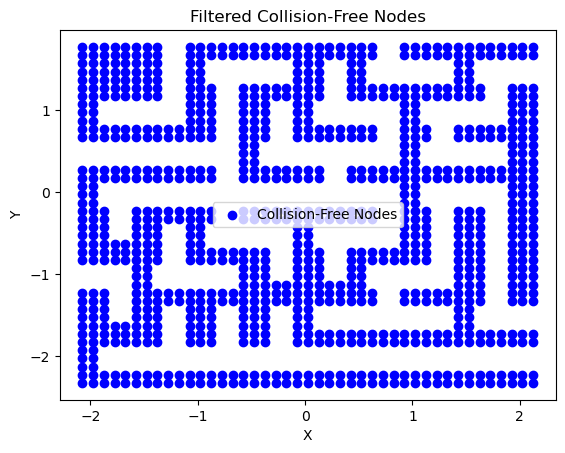

[[-2.07501982 -2.32521898]
 [-1.97501982 -2.32521898]
 [-1.87501982 -2.32521898]
 ...
 [ 1.92498018  1.77478102]
 [ 2.02498018  1.77478102]
 [ 2.12498018  1.77478102]]
[-0.175 -1.325]


In [18]:
collision_free_nodes=[]
for coord in node_grid.reshape(-1, 2):  # Flatten to a (N, 2) array
    if not check_collision(coord):  # If not in collision
        collision_free_nodes.append(tuple(coord))

collision_free_array = np.array(collision_free_nodes)
plt.scatter(collision_free_array[:, 0], collision_free_array[:, 1], label="Collision-Free Nodes", color="blue")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Filtered Collision-Free Nodes")
plt.show()

print(collision_free_array)
collision_free_array=np.round(collision_free_array,3)
print(collision_free_array[233])


In [19]:
graph={}
for coord1 in collision_free_array:
    key = tuple(coord1)  # Use a tuple for the dictionary key
    neighbors = []  # Initialize the list for neighbors
    for coord2 in collision_free_array:
        if (coord1 != coord2).all:
            distance=np.linalg.norm(coord1-coord2)
            if distance<=np.sqrt(cell_size**2 + cell_size**2)+0.001:
                neighbors.append((coord2, distance))
    graph[key]=neighbors
            
            
print(graph[(-2.075, -2.325)])
            
###first value is the node itself, the remaining nodes are neighbours

[(array([-2.075, -2.325]), 0.0), (array([-1.975, -2.325]), 0.10000000000000009), (array([-2.075, -2.225]), 0.10000000000000009), (array([-1.975, -2.225]), 0.14142135623730964)]


In [23]:
start_node=(-2.075, -2.325)
stop_node=(2.125, -1.325)

def aStarAlgo(start_node, stop_node, heuristic_func):
    open_set = set()
    closed_set = set()
    g = {}  # Dictionary to store the cost of getting to each node from the start node
    parents = {}  # Dictionary to store the parent node of each node in the path
    

    open_set.add(start_node)
    g[start_node] = 0
    parents[start_node] = None

    while open_set:
        current_node = get_node_with_lowest_f_score(open_set, g, stop_node)
        # goal has been reached
        if current_node == stop_node:
            return reconstruct_path(parents, current_node, start_node)
        open_set.remove(current_node)
        closed_set.add(current_node)
        for neighbor, cost in get_neighbors(current_node):
            if tuple(neighbor) in closed_set:
                continue
            tentative_g_score = g[current_node] + cost
            if tuple(neighbor) not in open_set or tentative_g_score < g[tuple(neighbor)]:
                parents[tuple(neighbor)] = current_node
                g[tuple(neighbor)] = tentative_g_score
                if tuple(neighbor) not in open_set:
                    open_set.add(tuple(neighbor))
    return None


def reconstruct_path(parents, current_node, start_node):
    path = []
    while current_node != start_node:
        path.insert(0, current_node)
        current_node = parents[current_node]
    path.insert(0, start_node)
    return path

def get_neighbors(node):
    neighbors = graph.get(node, [])
    return neighbors[1:]

def heuristic(node, goal):
    # These are the heuristic cost values presented in red in the graph above
    heuristic = {}
    for node_coords in collision_free_array:
        node_key = tuple(node_coords)
        goal_key = tuple(stop_node)
        distance = np.linalg.norm(node_coords - stop_node)
        heuristic[(node_key, goal_key)] = distance

    # for key, value in heuristic.items():
    #     print(f"{key}: {value:.2f}")

    return heuristic.get((node, goal), 0)  

def get_node_with_lowest_f_score(open_set, g, stop_node):
    lowest_f_score = float('inf')
    lowest_node = None
    for node in open_set:
        f_score=g[node] + heuristic(node,stop_node)
        if f_score < lowest_f_score:
            lowest_node = node
            lowest_f_score = f_score
    return lowest_node



In [24]:
path = aStarAlgo(start_node, stop_node, heuristic)
if path:
    print('Shortest Path:', path)
else:
    print('No path found.')

Shortest Path: [(-2.075, -2.325), (-1.975, -2.225), (-1.975, -2.125), (-1.975, -2.025), (-1.975, -1.925), (-1.875, -1.825), (-1.775, -1.725), (-1.675, -1.725), (-1.575, -1.625), (-1.475, -1.525), (-1.375, -1.425), (-1.275, -1.325), (-1.175, -1.325), (-1.075, -1.325), (-0.975, -1.325), (-0.875, -1.325), (-0.775, -1.325), (-0.675, -1.325), (-0.575, -1.325), (-0.475, -1.325), (-0.375, -1.325), (-0.275, -1.325), (-0.175, -1.325), (-0.075, -1.325), (0.025, -1.325), (0.125, -1.325), (0.225, -1.225), (0.325, -1.125), (0.425, -1.025), (0.525, -0.925), (0.625, -0.825), (0.725, -0.825), (0.825, -0.725), (0.925, -0.625), (1.025, -0.525), (1.025, -0.425), (1.025, -0.325), (1.025, -0.225), (1.025, -0.125), (1.025, -0.025), (1.025, 0.075), (1.125, 0.175), (1.225, 0.175), (1.325, 0.175), (1.425, 0.175), (1.525, 0.175), (1.625, 0.175), (1.725, 0.175), (1.825, 0.175), (1.925, 0.175), (2.025, 0.075), (2.025, -0.025), (2.025, -0.125), (2.025, -0.225), (2.025, -0.325), (2.025, -0.425), (2.025, -0.525), (2

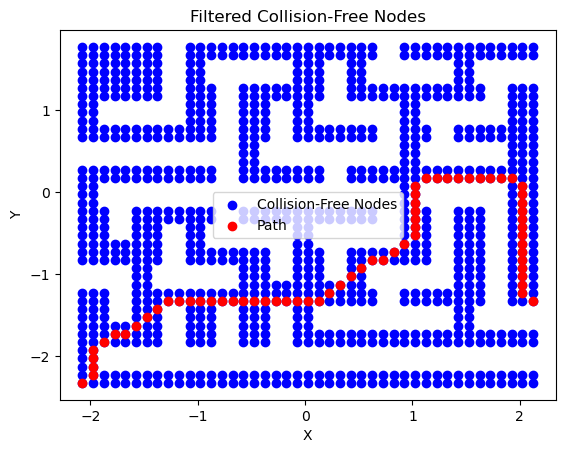

In [25]:
plt.scatter(collision_free_array[:, 0], collision_free_array[:, 1], label="Collision-Free Nodes", color="blue")
plt.scatter([node[0] for node in path], [node[1] for node in path], label="Path", color="red")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Filtered Collision-Free Nodes")
plt.show()

In [ ]:
#### NOW 3D


In [26]:
urdf_file = "model.urdf"
boxes = parse_collision_boxes(urdf_file)

global_min = np.array([float('inf'), float('inf'), float('inf')])
global_max = np.array([-float('inf'), -float('inf'), -float('inf')])

mins = []
maxs = []
for size, origin, rpy in boxes:
    min_coords, max_coords = compute_min_max(size, origin, rpy)
    mins.append(min_coords)
    maxs.append(max_coords)
    #print(f"Box: Size={size}, Origin={origin}, RPY={rpy}")
    #print(f"  Min: {min_coords}")
    #print(f"  Max: {max_coords}")
    
    # Update global bounds
    global_min = np.minimum(global_min, min_coords)
    global_max = np.maximum(global_max, max_coords)

print("\nGlobal Bounds:")
print(f"  Global Min: {global_min.round(3)}")
print(f"  Global Max: {global_max.round(3)}")


Global Bounds:
  Global Min: [-2.275 -2.525  0.   ]
  Global Max: [2.275 2.025 0.3  ]


In [27]:
buffer=0.1
adjusted_min = np.array(mins) - buffer
adjusted_max = np.array(maxs) + buffer

In [46]:
# Function to create a 2D grid with coordinates
cell_size = 0.1  # Adjust for finer or coarser grids

# Calculate number of rows and columns
rows = int(np.ceil((global_max[1] - global_min[1]) / cell_size))
cols = int(np.ceil((global_max[0]- global_min[0]) / cell_size))
depths = int(np.ceil((global_max[2] - global_min[2]) / cell_size)) 

# Create a 2D grid of coordinates
node_grid = np.zeros((rows, cols, depths, 3))  

# Fill the grid with node coordinates
for i in range(rows):  # Y-axis
    for j in range(cols):  # X-axis
        for k in range(depths):  # Z-axis
            x = global_min[0] + j * cell_size
            y = global_min[1] + i * cell_size
            z = global_min[2] + k * cell_size
            node_grid[i, j, k] = [x, y, z]

print("Node Grid Dimensions:", node_grid.shape)  # Should be (rows, cols, depths, 3)
print("Example Node at (0,0,0):", node_grid[0, 40, 0])



Node Grid Dimensions: (46, 46, 3, 3)
Example Node at (0,0,0): [ 1.72498018 -2.52521898  0.        ]


Collision-Free Array Shape: (2901, 3)
Example Collision-Free Node (index 233): [ 1.325 -2.225  0.2  ]


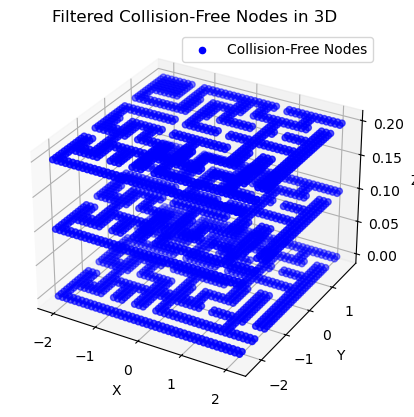

[[-2.075 -2.325  0.   ]
 [-2.075 -2.325  0.1  ]
 [-2.075 -2.325  0.2  ]
 ...
 [ 2.125  1.775  0.   ]
 [ 2.125  1.775  0.1  ]
 [ 2.125  1.775  0.2  ]]


In [50]:
collision_free_nodes = []
for coord in node_grid.reshape(-1, 3):  # Flatten to a (N, 3) array
    if not check_collision(coord):  # If not in collision
        collision_free_nodes.append(tuple(coord))

# Convert to NumPy array and round coordinates
collision_free_array = np.array(collision_free_nodes)
collision_free_array = np.round(collision_free_array, 3)

# Print a specific collision-free node
print("Collision-Free Array Shape:", collision_free_array.shape)
print("Example Collision-Free Node (index 233):", collision_free_array[233])

# 3D Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    collision_free_array[:, 0],
    collision_free_array[:, 1],
    collision_free_array[:, 2],
    label="Collision-Free Nodes",
    color="blue"
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Filtered Collision-Free Nodes in 3D")
plt.legend()
plt.show()
print(collision_free_array)

In [32]:
graph = {}
for coord1 in collision_free_array:
    key = tuple(coord1)  # Use a tuple for the dictionary key
    neighbors = []  # Initialize the list for neighbors
    for coord2 in collision_free_array:
        if not np.array_equal(coord1, coord2):  # Check if coords are not the same
            # Calculate 3D Euclidean distance
            distance = np.linalg.norm(coord1 - coord2)
            # Neighbor condition for 3D space
            if distance <= np.sqrt(cell_size**2 + cell_size**2 + cell_size**2) + 0.001:
                neighbors.append((tuple(coord2), distance))
    graph[key] = neighbors

example_node = tuple(collision_free_array[0])  #
if example_node in graph:
    print(f"Neighbors of {example_node}:")
    for neighbor, dist in graph[example_node]:
        print(f"  Neighbor: {neighbor}, Distance: {dist:.3f}")
else:
    print(f"{example_node} not found in graph.")


Neighbors of (-2.075, -2.325, 0.0):
  Neighbor: (-2.075, -2.325, 0.1), Distance: 0.100
  Neighbor: (-1.975, -2.325, 0.0), Distance: 0.100
  Neighbor: (-1.975, -2.325, 0.1), Distance: 0.141
  Neighbor: (-2.075, -2.225, 0.0), Distance: 0.100
  Neighbor: (-2.075, -2.225, 0.1), Distance: 0.141
  Neighbor: (-1.975, -2.225, 0.0), Distance: 0.141
  Neighbor: (-1.975, -2.225, 0.1), Distance: 0.173


Shortest Path: [(1.325, -2.225, 0.0), (1.225, -2.225, 0.0), (1.125, -2.225, 0.0), (1.025, -2.225, 0.0), (0.925, -2.225, 0.0), (0.825, -2.225, 0.0), (0.725, -2.225, 0.0), (0.625, -2.225, 0.0), (0.525, -2.225, 0.0), (0.425, -2.225, 0.0), (0.325, -2.225, 0.0), (0.225, -2.225, 0.0), (0.125, -2.225, 0.0), (0.025, -2.225, 0.0), (-0.075, -2.225, 0.0), (-0.175, -2.225, 0.0), (-0.275, -2.225, 0.0), (-0.375, -2.225, 0.0), (-0.475, -2.225, 0.0), (-0.575, -2.225, 0.0), (-0.675, -2.225, 0.0), (-0.775, -2.225, 0.0), (-0.875, -2.225, 0.0), (-0.975, -2.225, 0.0), (-1.075, -2.225, 0.0), (-1.175, -2.225, 0.0), (-1.275, -2.225, 0.0), (-1.375, -2.225, 0.0), (-1.475, -2.225, 0.0), (-1.575, -2.225, 0.0), (-1.675, -2.225, 0.0), (-1.775, -2.225, 0.0), (-1.875, -2.225, 0.0), (-1.975, -2.125, 0.0), (-1.975, -2.025, 0.0), (-1.975, -1.925, 0.0), (-1.875, -1.825, 0.0), (-1.775, -1.725, 0.0), (-1.675, -1.725, 0.0), (-1.575, -1.625, 0.0), (-1.475, -1.525, 0.0), (-1.375, -1.425, 0.0), (-1.275, -1.325, 0.0), (-1.175, 

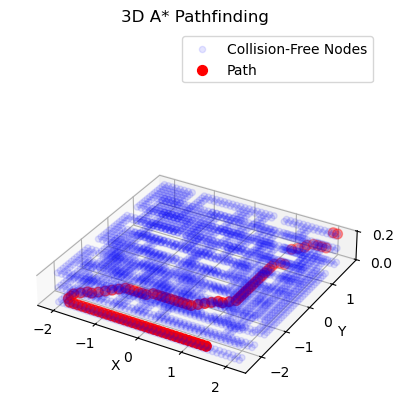

In [51]:
from mpl_toolkits.mplot3d import Axes3D

start_node = (1.325, -2.225, 0.0)  # 3D start node
stop_node = (2.125,  1.775,  0.2 )  # 3D stop node

def aStarAlgo(start_node, stop_node, heuristic_func):
    open_set = set()
    closed_set = set()
    g = {}  # Cost from start to each node
    parents = {}  # Parent node for reconstructing path
    
    open_set.add(start_node)
    g[start_node] = 0
    parents[start_node] = None

    while open_set:
        current_node = get_node_with_lowest_f_score(open_set, g, stop_node)
        if current_node == stop_node:  # Goal reached
            return reconstruct_path(parents, current_node, start_node)
        
        open_set.remove(current_node)
        closed_set.add(current_node)

        for neighbor, cost in get_neighbors(current_node):
            if neighbor in closed_set:
                continue

            tentative_g_score = g[current_node] + cost
            if neighbor not in open_set or tentative_g_score < g.get(neighbor, float('inf')):
                parents[neighbor] = current_node
                g[neighbor] = tentative_g_score
                if neighbor not in open_set:
                    open_set.add(neighbor)
    
    return None  # Path not found

def reconstruct_path(parents, current_node, start_node):
    path = []
    while current_node != start_node:
        path.insert(0, current_node)
        current_node = parents[current_node]
    path.insert(0, start_node)
    return path

def get_neighbors(node):
    return graph.get(node, [])  # Already stored as (neighbor, cost)

def heuristic(node, goal):
    # 3D Euclidean distance as heuristic
    return np.linalg.norm(np.array(node) - np.array(goal))

def get_node_with_lowest_f_score(open_set, g, stop_node):
    lowest_f_score = float('inf')
    lowest_node = None
    for node in open_set:
        f_score = g[node] + heuristic(node, stop_node)
        if f_score < lowest_f_score:
            lowest_node = node
            lowest_f_score = f_score
    return lowest_node

# Run A* Algorithm
path = aStarAlgo(start_node, stop_node, heuristic)
if path:
    print('Shortest Path:', path)
else:
    print('No path found.')

# Optional: Plot the 3D path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter collision-free nodes (50% opaque)
ax.scatter(
    collision_free_array[:, 0],
    collision_free_array[:, 1],
    collision_free_array[:, 2],
    label="Collision-Free Nodes",
    color="blue",
    alpha=0.1  # Set opacity to 50%
)

# Plot the path with red dots
if path:
    path_array = np.array(path)
    ax.scatter(
        path_array[:, 0],
        path_array[:, 1],
        path_array[:, 2],
        label="Path",
        color="red",
        s=50  # Size of the red dots
    )

ax.set_zlim(0.0, 0.2)  # Limit the z-axis range to [0.0, 0.2]
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.2, 1]))
ax.set_zticks([0.0,0.2])  # Add specific ticks for the z-axis

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D A* Pathfinding")
plt.legend()
plt.show()
